In [15]:
import pandas as pd

print("\nFile Type : .ipynb\n")

try:
    get_ipython().run_line_magic('load_ext', 'autoreload')      # %load_ext autoreload
    get_ipython().run_line_magic('autoreload', '2')             # %autoreload 2
    from IPython.core.interactiveshell import InteractiveShell
    InteractiveShell.ast_node_interactivity = "all"
except:
    pass

#make necesarry imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation, cosine
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt
import sys, os
from contextlib import contextmanager
from pandas.core.reshape.pivot import pivot_table

from scipy.sparse.linalg import svds

import warnings
warnings.filterwarnings('ignore')


File Type : .ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
def get_pivot(df):
    
    df = df.pivot_table(columns='book_id', index='user_id', values="rating").reset_index().rename_axis(None, axis=1)

    user_id_map = df['user_id']      # saving user index map for later reference
    df.drop(['user_id'],axis=1,inplace=True)
    
    return user_id_map, df

def get_similar_user_matrix(df, metric = 'cosine'):
    
    df.fillna(0,inplace=True)
    df = pd.DataFrame(1-pairwise_distances(df, metric=metric,force_all_finite=True))
    
    return df

In [35]:
# variables
train_test_split_ratio = 0.7
user_count = 5                                # k nearest neighbors for users

### INPUT DATA

In [20]:
interactions_df = pd.read_csv('../sample/interactions.csv', index_col=0).reset_index(drop=True)
interactions_df.drop(columns=['review_text_incomplete','read_at','started_at','review_id','is_read','date_updated'], inplace=True)

user_id_map_df = pd.read_csv('../sample/user_id_map.csv')

interactions_df = pd.merge(interactions_df,user_id_map_df,how="inner",on="user_id")

interactions_df.drop(columns=['user_id'], inplace=True)

interactions_df['user_id'] = interactions_df['user_id_csv']
interactions_df.drop(columns=['user_id_csv'], inplace=True)

books_df = pd.read_csv('../sample/top_1000_books.csv', index_col=0).reset_index(drop=True)
book_titles = books_df[['book_id','title']]

interactions_df = pd.merge(interactions_df, book_titles, on='book_id')

# interactions_df.head()

In [1]:
# filtering out users who have given less than 50 ratings. 
x = interactions_df['user_id'].value_counts() > 50
y = x[x].index  #user_ids
interactions_df = interactions_df[interactions_df['user_id'].isin(y)]

interactions_df = interactions_df.reset_index()
interactions_df.drop(columns=['index'], inplace=True)
# interactions_df.head()

# filtering out books with less than 5 ratings. 
x = interactions_df['book_id'].value_counts() > 5
y = x[x].index  #user_ids
interactions_df = interactions_df[interactions_df['book_id'].isin(y)]

# sorting the data by date 
interactions_df['date_added'] = pd.to_datetime(interactions_df['date_added'])
interactions_df.sort_values('date_added', inplace = True)

# interactions_df.head()

## Choosing optimum k by train test

#### TRAIN TEST SPLIT

In [53]:
# train test split
split_value = int(train_test_split_ratio * len(interactions_df))
train_interaction = interactions_df[0:split_value]
test_interaction = interactions_df[split_value:]

# pivots
train_user_map, train_data = get_pivot(train_interaction)
test_user_map, test_data = get_pivot(test_interaction)

print('Percentage of overlapped users in train and test w.r.t. to train: ', 100*len(list(set(train_user_map).intersection(set(test_user_map))))/len(train_data))

train_data.to_csv('../Data/train_interaction_pivot.csv', index=False)
test_data.to_csv('../Data/test_interaction_pivot.csv', index=False)
train_user_map.to_csv('../Data/train_user_map.csv', index=False)
test_user_map.to_csv('../Data/test_user_map.csv', index=False)

Percentage of overlapped users in train and test w.r.t. to train:  81.92036350591893


In [2]:
train_data = pd.read_csv('../Data/train_interaction_pivot.csv')
# train_data.fillna(0,inplace=True)
# train_data.sample(5)

#### COSINE SIMILARITY 

In [54]:
cosine_sim_train = get_similar_user_matrix(train_data, metric = 'cosine')
cosine_sim_train.to_csv('../Data/cosine_sim_train.csv', index=False)
cosine_sim_train.head()

,0,1,2,3,4,5,6,7,8,9,...,8353,8354,8355,8356,8357,8358,8359,8360,8361,8362
0,1.000000,0.000000,0.330483,0.607752,0.000000,0.000000,0.000000,0.000000,0.000000,0.336718,...,0.000000,0.055497,0.00000,0.056026,0.000000,0.084399,0.000000,0.000000,0.000000,0.058449
1,0.000000,1.000000,0.018313,0.014885,0.209090,0.093248,0.354959,0.343351,0.129649,0.039805,...,0.166134,0.204199,0.00000,0.196709,0.195656,0.000000,0.134295,0.228526,0.308536,0.212471
2,0.330483,0.018313,1.000000,0.263035,0.000000,0.000000,0.000000,0.000000,0.000000,0.245371,...,0.000000,0.040441,0.00000,0.040827,0.000000,0.226112,0.000000,0.016008,0.025157,0.130440
3,0.607752,0.014885,0.263035,1.000000,0.016789,0.000000,0.018354,0.033032,0.000000,0.290850,...,0.000000,0.091423,0.09972,0.041481,0.000000,0.077190,0.000000,0.000000,0.020448,0.098450
4,0.000000,0.209090,0.000000,0.016789,1.000000,0.000000,0.101637,0.164183,0.123226,0.044896,...,0.142096,0.163716,0.00000,0.134463,0.158544,0.000000,0.108192,0.224945,0.187805,0.236719


####  Predictions for test data based on train model

In [ ]:
test_data.fillna(0,inplace=True)

for user_count in range(50):
    result_df = pd.DataFrame(columns=['row','col','actual','predicted'])

    for col in range(test_data.shape[1]):
        temp = np.array(test_data.iloc[:,col]).nonzero()[0]

        for row in temp:
            book_id    = test_data.columns[col]

            try:
                user_id    = train_user_map[train_user_map == test_user_map[row]].index[0]
                user_index = list(train_data[train_data[book_id]>0][book_id].index)

                filtered_user = pd.DataFrame(cosine_sim_train.loc[user_id,user_index]).sort_values(user_id, ascending=False).head(user_count)

                predicted_rating = train_data[book_id][filtered_user.index].mean()   

                local_result = [row,col,test_data.iloc[row,col], predicted_rating]
                result_df.loc[len(result_df)] = local_result

            except:
                pass
    
    result_df['iteration'] = user_count
    result_df.to_csv('../output/user_cf_train_test_results/'+str(user_count)+'_user-user_cosine_sim_CF_test_result.csv', index = False)

Text(0.5, 0, 'k')

Text(0, 0.5, 'rmse')

Text(0.5, 1.0, 'RMSE_vs_k')

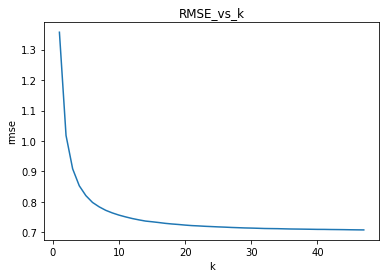

In [50]:
rmse_df = pd.DataFrame(columns=['k', 'rmse'])

for user_count in range(1,500):
    try:
        temp  = pd.read_csv('../output/user_cf_train_test_results/'+str(user_count)+'_user-user_cosine_sim_CF_test_result.csv')
        temp  = temp.dropna()
        rmse  = mean_squared_error(temp['actual'], temp['predicted'])
        local = [user_count,rmse]
        rmse_df.loc[len(rmse_df)] = local
    except:
        break
        
plt.plot(rmse_df['k'],rmse_df['rmse'])
plt.xlabel('k')
plt.ylabel('rmse')
plt.title('RMSE_vs_k')
plt.show()

#### By elbow method, best k for the given model = 5

## Recommendation 

In [51]:
user_count = 5

In [36]:
user_map, data = get_pivot(interactions_df)

data.to_csv('../Data/full_interaction_pivot.csv', index=False)
user_map.to_csv('../Data/full_user_map.csv', index=False)

cosine_sim = get_similar_user_matrix(data, metric = 'cosine')
cosine_sim.to_csv('../Data/cosine_sim_full_data.csv', index=False)

In [37]:
data.fillna(0,inplace=True)

result_df = pd.DataFrame(columns=['row','col','actual','predicted'])

def rating_by_user_cf(df,user):
    
    predicted_df = df.copy(deep=True)
    row = user
    
    for col in range(df.shape[1]):

        if(df.iloc[row,col]!=0):
            predicted_df[row,col] = None
            pass
        else:
            book_id    = df.columns[col]
            user_id    = row

            user_index = list(df[df[book_id]>0][book_id].index)

            filtered_user = pd.DataFrame(cosine_sim.loc[user_id,user_index]).sort_values(user_id, ascending=False).head(user_count)
                        
            predicted_rating = df[book_id][filtered_user.index].mean()   

            predicted_df.iloc[row,col] = predicted_rating
            
    return predicted_df, filtered_user


In [38]:
# Recommending top 10 books based on ratings

def Recommend_book(df,user,number_of_books):
    '''
    Recommendation on basis of user-user similarity 
    '''
    
    predicted_ratings,similar_user = rating_by_user_cf(df,user)
        
    ls = list(pd.DataFrame(predicted_ratings.iloc[user,:]).sort_values(user, ascending=False).head(number_of_books).index)
    
    print('This user has rated',len(np.array(data.iloc[user,:]).nonzero()[0]), 'books.')
    
    return book_titles[book_titles['book_id'].isin(ls)]

In [40]:
Recommend_book(data,user=0,number_of_books=10)

This user has rated 55 books.


## MF using SVD

### Cross Validation

In [96]:
# Taking 5 folds

index_df = pd.DataFrame(columns=['row','col','row_col'])
for col in range(data.shape[1]):
        temp = np.array(data.iloc[:,col]).nonzero()[0]
        
        for row in temp:
            
            local = [row,col,(row,col)]
            index_df.loc[len(index_df)] = local

index_df['Decile_rank'] = pd.qcut(index_df.index, 5, labels = False)

In [3]:
# index_df

In [90]:
ls = index_df['row_col'][index_df['Decile_rank'] == 1].reset_index(drop=True)

for cv_k in index_df['Decile_rank'].unique():
    
    ls = index_df['row_col'][index_df['Decile_rank'] == cv_k].reset_index(drop=True)
    
    cv_train = data.copy()
    for i in range(len(ls)):
        cv_train.iloc[ls[i]] = 0

    U, sigma, Vt = svds(cv_train, k = 50)

    sigma = np.diag(sigma)

    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)   

    preds_df = pd.DataFrame(all_user_predicted_ratings, columns = data.columns)
    # preds_df.head()

    y_actual = []
    y_pred = []
    for i in range(len(ls)):
        y_actual.append(data.iloc[ls[i]])
        y_pred.append(preds_df.iloc[ls[i]])

    print('Decile',cv_k, mean_squared_error(y_actual,y_pred))

Decile 0 7.554006574528652
Decile 1 6.086190054572751
Decile 2 7.033729088431938
Decile 3 7.554382060297192
Decile 4 5.653990285737608


#### By cross validation, it's a stable model,because rmse for all five folds is almost same

#### Choosing k (no of features)

In [92]:
data.shape

(9096, 1000)

In [ ]:
ls = index_df['row_col'][index_df['Decile_rank'] == 1].reset_index(drop=True)

for cv_k in index_df['Decile_rank'].unique():
    
    ls = index_df['row_col'][index_df['Decile_rank'] == cv_k].reset_index(drop=True)
    
    data = data.copy()
    for i in range(len(ls)):
        data.iloc[ls[i]] = 0

    U, sigma, Vt = svds(data, k = 50)

    sigma = np.diag(sigma)

    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)   

    preds_df = pd.DataFrame(all_user_predicted_ratings, columns = data.columns)
    # preds_df.head()

    y_actual = []
    y_pred = []
    for i in range(len(ls)):
        y_actual.append(data.iloc[ls[i]])
        y_pred.append(preds_df.iloc[ls[i]])

    print('Decile',cv_k, mean_squared_error(y_actual,y_pred))

In [98]:
ls = index_df['row_col'][index_df['Decile_rank'] == 1].reset_index(drop=True)
rmse_df = pd.DataFrame(columns=['k','rmse'])

for k in range(0,500,5):

    for cv_k in index_df['Decile_rank'].unique():
    
        ls = index_df['row_col'][index_df['Decile_rank'] == cv_k].reset_index(drop=True)

        data = data.copy()
        for i in range(len(ls)):
            data.iloc[ls[i]] = 0

        U, sigma, Vt = svds(data, k = 50)

        sigma = np.diag(sigma)

        all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)   

        preds_df = pd.DataFrame(all_user_predicted_ratings, columns = data.columns)
        # preds_df.head()

        y_actual = []
        y_pred = []
        for i in range(len(ls)):
            y_actual.append(data.iloc[ls[i]])
            y_pred.append(preds_df.iloc[ls[i]])

        rmse_for_5_deciles.append(mean_squared_error(y_actual,y_pred))
    avg_rmse = sum(rmse_for_5_deciles)/len(rmse_for_5_deciles)
    print( 'k=',k, ':',avg_rmse)
        
    local = [k,avg_rmse]
    rmse_df.loc[len(rmse_df)] = local

    rmse_df.to_csv('../output/svd_cv_results/'+str(k)+'_cv5_svd_rmse.csv', index = False)

k= 0 : 0.8661833167482693
k= 5 : 0.8120468594515025
k= 10 : 0.7642793971308258
k= 15 : 0.7218194306235577
k= 20 : 0.6838289342749494
k= 25 : 0.649637487561202
k= 30 : 0.6187023691059066
k= 35 : 0.5905795341465473
k= 40 : 0.5649021630966974
k= 45 : 0.5413645729676683
k= 50 : 0.5197099900489616
k= 55 : 0.49972114427784764
k= 60 : 0.4812129537490385
k= 65 : 0.46402677682943
k= 70 : 0.4480258534904841
k= 75 : 0.43309165837413466
k= 80 : 0.4191209597169045
k= 85 : 0.40602342972575123
k= 90 : 0.39371968943103147
k= 95 : 0.3821396985654129
k= 100 : 0.371221421463544
k= 105 : 0.36090971531177884
k= 110 : 0.3511553986817308
k= 115 : 0.3419144671374747
k= 120 : 0.33314742951856513
k= 125 : 0.324818743780601
k= 130 : 0.3168963353957083
k= 135 : 0.3093511845529533
k= 140 : 0.3021569709586986
k= 145 : 0.29528976707327365
k= 150 : 0.2887277722494231
k= 155 : 0.2824510815483487
k= 160 : 0.2764414840685966
k= 165 : 0.27068228648383413
k= 170 : 0.2651581581882457
k= 175 : 0.2598549950244808
k= 180 : 0.

Text(0.5, 0, 'k')

Text(0, 0.5, 'rmse')

Text(0.5, 1.0, 'RMSE_vs_NFeatures')

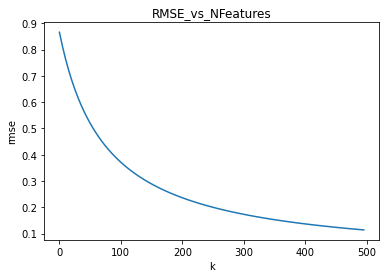

In [103]:
# rmse_df

plt.plot(rmse_df['k'],rmse_df['rmse'])
plt.xlabel('k')
plt.ylabel('rmse')
plt.title('RMSE_vs_NFeatures')
plt.show()

#### By elbow method, optimum number of features = 100

### Final Model

In [40]:
# train_data.fillna(0,inplace=True)

# R = np.array(train_data)
# # R = train_data.as_matrix()
# user_ratings_mean = np.mean(R, axis = 1)
# user_ratings_std = np.std(R, axis=1)
# R_demeaned = R - user_ratings_mean.reshape(-1, 1)


In [113]:
data = pd.read_csv('../Data/full_interaction_pivot.csv')
data

,866,868,869,870,871,873,2879,2880,2881,2882,...,28762820,28862528,29237211,29396738,29436571,29772863,30754980,31145178,31338724,32497573
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9091,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
def get_rating_by_svd(df,NFeatures=100):
    
    U, sigma, Vt = svds(data, k = 50)

    sigma = np.diag(sigma)

    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

    preds_df = pd.DataFrame(all_user_predicted_ratings, columns = data.columns)
    
    return preds_df

In [115]:
preds_df.head()

,866,868,869,870,871,873,2879,2880,2881,2882,...,28762820,28862528,29237211,29396738,29436571,29772863,30754980,31145178,31338724,32497573
0,-0.119670,0.210190,-0.025820,0.865060,0.063717,0.185647,0.005162,1.034669,-0.044253,-0.004269,...,0.165154,-0.012564,0.154337,-0.010429,-0.037867,-0.041256,-0.078031,0.037302,-0.101250,-0.001973
1,-0.038209,-0.116862,-0.022867,-0.037147,-0.108020,-0.119452,0.012503,-0.065194,0.023437,-0.005712,...,-0.044619,0.120975,0.157280,0.036785,-0.116981,0.077430,-0.019649,-0.137984,0.440162,-0.018388
2,0.094925,0.090543,0.074824,0.884244,0.094868,0.152414,-0.132885,0.611852,-0.124166,0.087418,...,0.175271,0.093523,0.104184,0.035642,-0.018849,0.012161,0.208520,0.009271,-0.189100,0.030776
3,4.145276,4.309923,4.206345,4.226644,4.266396,4.365741,2.983141,3.485902,2.980847,3.039808,...,-0.124324,-0.054673,0.051115,0.000744,0.006241,0.003880,0.100111,0.019605,0.093459,0.011634
4,-0.019431,-0.043728,-0.037368,0.248388,-0.046373,-0.067598,0.034953,0.087216,0.013036,-0.043514,...,0.157488,0.684759,0.292035,0.070321,0.250125,0.279205,0.327987,0.169470,0.547378,0.041657


In [45]:
# Recommending top 10 books based on ratings

def Recommend_book_svd(df,user,number_of_books):
    '''
    Recommendation on basis of svd 
    '''
    
    predicted_ratings = get_rating_by_svd(df)
        
    ls = list(pd.DataFrame(predicted_ratings.iloc[user,:]).sort_values(user, ascending=False).head(number_of_books).index.astype(int))
    print(ls)
    print('This user has rated',len(np.array(data.iloc[user,:]).nonzero()[0]), 'books.')
    
    return book_titles[book_titles['book_id'].isin(ls)]

In [50]:
Recommend_book_svd(data,user=0,number_of_books=10)

[13615, 13619, 13618, 13616, 13617, 13620, 568472, 204045, 204044, 400629]
This user has rated 55 books.


,book_id,title
3,13615,"Death Note, Vol. 1: Boredom (Death Note, #1)"
146,13619,"Death Note, Vol. 2: Confluence (Death Note, #2)"
171,13618,"Death Note, Vol. 3: Hard Run (Death Note, #3)"
187,13616,"Death Note, Vol. 4: Love (Death Note, #4)"
214,13617,"Death Note, Vol. 5: Whiteout (Death Note, #5)"
221,13620,"Death Note, Vol. 6: Give-and-Take (Death Note,..."
262,204045,"Naruto, Vol. 05: Exam Hell (Naruto, #5)"
333,204044,"Naruto, Vol. 03: Bridge of Courage (Naruto, #3)"
362,568472,"Naruto, Vol. 04: The New Opponents (Naruto, #4)"
425,400629,"Naruto, Vol. 07: Orochimaru's Curse (Naruto, #7)"
